# Part 1

# Part 1.1

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco

# Function to standardize column names to match the first DataFrame
def apply_column_names(df, column_names):
    df.columns = column_names[1:len(df.columns)+1]  # Skip the first name since it corresponds to the Date column
    return df

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import scipy.optimize as sco

# Load the returns data
df = pd.read_excel(
    r"C:\Users\marko\OneDrive\Bureau\Marko_documents\Etudes\Master_1ère\2ème_semestre\Sustainability Aware Asset Management\Data (1)\DS_RI_T_USD_M.xlsx",
    header=None,
)

# Transpose the DataFrame
df = df.T

# Set the second row (index 1) as the column headers
df.columns = df.iloc[0]
column_names = df.iloc[1].values
print(column_names)

# Remove the first two rows as they are now redundant
df = df.drop([0, 1])

# Rename the first column to 'Date' and set it as the index
df = df.rename(columns={df.columns[0]: "Date"}).set_index("Date")

# Convert all entries to floats for uniformity and handling
df = df.astype(float)

# Initialize a set to keep track of dropped stocks
dropped_stocks = set()

# 1. Remove stocks with initial zero prices
initial_zeros = df.iloc[0] == 0
dropped_stocks.update(df.columns[initial_zeros])
print(f"Initial zero : {df.columns[initial_zeros]}")
df = df.loc[:, ~initial_zeros]

# 2. Remove stocks that ever drop to zero
ever_zeros = (df == 0).any()
dropped_stocks.update(df.columns[ever_zeros])
print(f"Ever zero : {df.columns[ever_zeros]}")
df = df.loc[:, ~ever_zeros]

# 3. Remove stocks that do not recover after dropping to zero
max_prior = df.cummax()
recovered = ((df / max_prior.shift()) > 0.1).any()
non_recovered = df.columns[~recovered]
dropped_stocks.update(non_recovered)
print(f"Non recovered : {non_recovered}")
df = df.loc[:, recovered]

# Filter based on sector information
static_file = pd.read_excel(r'C:\Users\marko\OneDrive\Bureau\Marko_documents\Etudes\Master_1ère\2ème_semestre\Sustainability Aware Asset Management\Data (1)\Static.xlsx')
sectors = ['Energy', 'Materials', 'Utilities', 'Industrials']
companies = static_file[static_file['GICSSectorName'].isin(sectors)]
isin_list = companies['ISIN'].tolist()

# Identify stocks that are not in the highly polluting sectors
non_polluting_stocks = set(df.columns) - set(isin_list)
dropped_stocks.update(non_polluting_stocks)

df = df[df.columns.intersection(isin_list)]


# Reset column names to the original names after modifications
df.columns = column_names[1:len(df.columns)+1]  # Skip the first name since it corresponds to the Date column

# Proceed with any further data processing, such as calculating returns
monthly_returns = df.pct_change()
monthly_returns = monthly_returns.drop(monthly_returns.index[0])

# Handling NaN and infinite values
monthly_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
monthly_returns.interpolate(method='linear', axis=0, inplace=True)
monthly_returns.fillna(method='ffill', axis=0, inplace=True)
monthly_returns.fillna(method='bfill', axis=0, inplace=True)

# Display results
print("Remaining NaN values in monthly returns:", monthly_returns.isnull().sum().sum())
df


['NAME' 'SCHLUMBERGER' 'ALUAR' ... 'NORTHAM PLATINUM HLDGS' 'AVENG'
 'NAMPAK']
Initial zero : Index(['ID1000094204', 'ID1000096605', 'ID1000108905'], dtype='object', name=0)
Ever zero : Index(['GRS014003032', 'ID1000061302', 'ID1000066004', 'ID1000092703',
       'ID1000099302', 'ID1000105604', 'ID1000110000', 'ID1000122807',
       'IT0005508921', 'KR7000660001', 'KR7000720003', 'KR7001440007',
       'KR7005880000', 'KR7011810009', 'NO0010861990'],
      dtype='object', name=0)
Non recovered : Index([], dtype='object', name=0)
Remaining NaN values in monthly returns: 0


C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1286695583.py:77: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_returns.fillna(method='ffill', axis=0, inplace=True)
C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1286695583.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_returns.fillna(method='bfill', axis=0, inplace=True)


,SCHLUMBERGER,ALUAR,BBVA BANCO FRANCES,TERNIUM ARGENTINA SOCIEDAD ANONIMA,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,...,AEON FINANCIAL SERVICE,IHI,ISUZU MOTORS,ITO EN,ITOCHU,ITOCHU TECHNO-SOLUTIONS,IBIDEN,USHIO,UBE,EISAI
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,1858.26,1820.11,177.53,156.25,389.64,524.60,2379.46,154.48,111.26,496.60,...,279.62,11.14,758.04,3353.95,548.68,29.64,65.68,4.13,21.22,120.95
2000-02-29,2254.15,1911.12,184.55,153.83,318.75,564.59,2203.58,147.40,113.86,339.60,...,235.67,8.98,620.90,2733.96,527.94,19.97,67.58,3.38,21.61,118.15
2000-03-31,2334.75,1866.11,184.16,158.62,311.41,518.56,2451.55,148.80,104.32,335.65,...,237.29,8.13,465.76,2705.15,492.10,19.09,55.68,3.25,18.52,105.83
2000-04-30,2336.65,1835.93,171.05,137.27,335.24,463.37,2552.81,136.90,97.96,296.32,...,230.06,8.97,484.24,2473.54,475.08,15.80,48.49,2.52,16.75,106.20
2000-05-31,2245.09,1805.22,112.65,148.95,356.91,498.05,2746.80,132.23,100.94,251.09,...,230.57,9.00,390.54,2604.74,416.18,15.99,47.19,2.68,13.14,86.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,3537.17,5459.78,1428.06,1215.93,3758.17,7555.23,5022.24,847.25,1135.16,4558.87,...,1990.48,346.84,890.50,15685.52,6218.06,40.45,47.36,79.08,0.15,13.73
2022-09-30,3344.15,4847.48,1263.78,1190.06,3396.99,6751.05,4318.66,718.38,979.78,3577.98,...,2121.39,283.80,581.25,14806.19,5486.22,33.46,40.16,72.97,0.13,10.12
2022-10-31,4846.68,4827.59,1286.25,1198.76,4277.10,6172.06,4894.01,909.74,1078.30,3064.06,...,2194.61,317.02,438.33,16052.73,5800.45,34.71,38.42,78.43,0.13,10.06


In [55]:
# Function to load and clean data
def clean_and_handle_missing_values(file_path):
    df = pd.read_excel(file_path).T
    df.columns = df.iloc[0]
    df = df.drop(columns=list(dropped_stocks), errors='ignore')
    df.columns = df.iloc[1]
    df = apply_column_names(df, column_names)
    df = df.drop(df.index[1])
    df.reset_index(inplace=True)
    df = df.rename(columns={'index': 'Date'})
    df.set_index('Date', inplace=True)
    df = df.drop(df.index[0:7])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.interpolate(method='linear', axis=0, inplace=True)
    df.fillna(method='ffill', axis=0, inplace=True)
    df.fillna(method='bfill', axis=0, inplace=True)
    return df


# Rolling Window

In [34]:
import pandas as pd
import numpy as np
import cupy as cp
import scipy.optimize as sco
from numba import jit
from tqdm import tqdm


# Assuming returns are loaded into 'returns' DataFrame
# Convert DataFrame to CuPy array for efficient GPU operations, assuming 'NAME' column removed if present
returns_cp = cp.asarray(monthly_returns.values)
dates = monthly_returns.index

# Define the objective function using CuPy for GPU acceleration
def objective(weights, cov_matrix):
    return cp.dot(weights, cp.dot(cov_matrix, weights))

# Define constraints and bounds using scipy, which interacts with CPU memory
def constraints(weights):
    return np.sum(weights) - 1  # Ensure the sum of weights is 1

bounds = [(0, 1) for _ in range(returns_cp.shape[1])]  # Non-negative weights

# Optimization function using constraints
def optimize_portfolio(returns, num_assets):
    # Calculate covariance matrix on GPU
    cov_matrix = cp.cov(returns, rowvar=False)
    initial_weights = np.full(num_assets, 1.0 / num_assets)
    result = sco.minimize(lambda w: cp.asnumpy(objective(cp.asarray(w), cov_matrix)),
                          initial_weights, method='SLSQP', bounds=bounds,
                          constraints={'type': 'eq', 'fun': constraints})
    return cp.asarray(result.x)

# Monthly returns update using Numba for fast execution
@jit(nopython=True)
def update_weights_numba(weights, returns, portfolio_return):
    new_weights = np.zeros_like(weights)
    for i in range(len(weights)):
        new_weights[i] = weights[i] * (1 + returns[i]) / (1 + portfolio_return)
    return new_weights / np.sum(new_weights)

# Calculate and update returns for the next year using the computed weights
def update_weights(weights, returns, portfolio_return):
    # Ensure inputs are in NumPy format for Numba compatibility
    weights_np = cp.asnumpy(weights)
    returns_np = cp.asnumpy(returns)
    portfolio_return_np = portfolio_return.get() if isinstance(portfolio_return, cp.ndarray) else portfolio_return
    
    # Call the Numba JIT function
    updated_weights_np = update_weights_numba(weights_np, returns_np, portfolio_return_np)
    
    # Convert back to CuPy array for further GPU processing
    return cp.asarray(updated_weights_np)

# Rolling window and rebalance portfolio
start_year = 1999
end_year = 2021
optimal_weights_annual = {}
optimal_weights_monthly = {}
portfolio_returns = pd.Series(dtype=float, index=monthly_returns.index)

for year in tqdm(range(start_year, end_year - 6 + 1), desc="Calculating optimal weights"):
    # Define training data for the 6-year window
    if year == start_year:
        start_index = ((year - start_year) * 12)
        end_index = start_index + (6 * 12) - 1
    else:
        start_index = ((year - start_year) * 12) - 1
        end_index = start_index + (6 * 12)

    if end_index < returns_cp.shape[0]:
        train_returns = returns_cp[start_index:end_index]
        weights = optimize_portfolio(train_returns, returns_cp.shape[1])
        optimal_weights_annual[year + 6] = weights

        # Calculate and update returns for the next year using the computed weights
        for month in range(12):
            month_idx = end_index + month
            if month_idx < returns_cp.shape[0]:  # Check within data range
                month_returns = returns_cp[month_idx]
                portfolio_return = cp.dot(month_returns, weights)  # Monthly portfolio return
                portfolio_returns[dates[month_idx]] = portfolio_return
                optimal_weights_monthly[month_idx] = weights
                # Update weights for next month
                weights = update_weights(weights, month_returns, portfolio_return)

# Calculate performance metrics similar to previous explanations


Calculating optimal weights: 100%|██████████| 17/17 [31:08<00:00, 109.90s/it]


In [72]:
# Save results

import pandas as pd

portfolio_returns_df = pd.DataFrame(portfolio_returns, index=dates, columns=['Returns'])
portfolio_returns_df.to_csv('portfolio_returns_hp.csv')

# Convert dictionary to DataFrame
annual_weights_df = pd.DataFrame.from_dict(optimal_weights_annual, orient='index')

# Save to CSV
annual_weights_df.to_csv('annual_optimal_weights_hp.csv')

# Monthly weights might require some transformation since they're indexed by months
monthly_weights_df = pd.DataFrame.from_dict(optimal_weights_monthly, orient='index')

# Save to CSV
monthly_weights_df.to_csv('monthly_optimal_weights_hp.csv')

In [73]:
import pandas as pd
import numpy as np

# Assuming the CSV file is saved in the same directory as your script, or provide the full path
file_path = 'portfolio_returns_hp.csv'
portfolio_returns_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)  # Assuming 'Date' is the column for dates
portfolio_returns_df.dropna(inplace=True)
portfolio_returns = pd.Series(portfolio_returns_df['Returns'], dtype=float, index=portfolio_returns_df.index)
# Check the first few rows to ensure it's loaded correctly
print(portfolio_returns)


Date
2006-01-31    0.055217
2006-02-28    0.024178
2006-03-31    0.015482
2006-04-30    0.045664
2006-05-31   -0.019783
                ...   
2022-08-31   -0.023406
2022-09-30   -0.078631
2022-10-31   -0.004662
2022-11-30    0.050419
2022-12-31    0.010493
Name: Returns, Length: 204, dtype: float64


In [74]:
# Compute performance metrics
annual_returns = portfolio_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return = annual_returns.mean()
annualized_volatility = annual_returns.std() * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility
cumulative_returns = (1 + portfolio_returns.fillna(0)).cumprod()
peak = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

# Output results
print(f"Annualized Return: {annualized_return}")
print(f"Annualized Volatility: {annualized_volatility}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")
print(f"Max returns: {portfolio_returns.max()}")
print(f"Min returns: {portfolio_returns.min()}")


Annualized Return: 0.10543546638080248
Annualized Volatility: 0.5620805223945313
Sharpe Ratio: 0.187580715182292
Max Drawdown: -0.25117515515725863
Max returns: 0.1046319412005317
Min returns: -0.1251072359958845


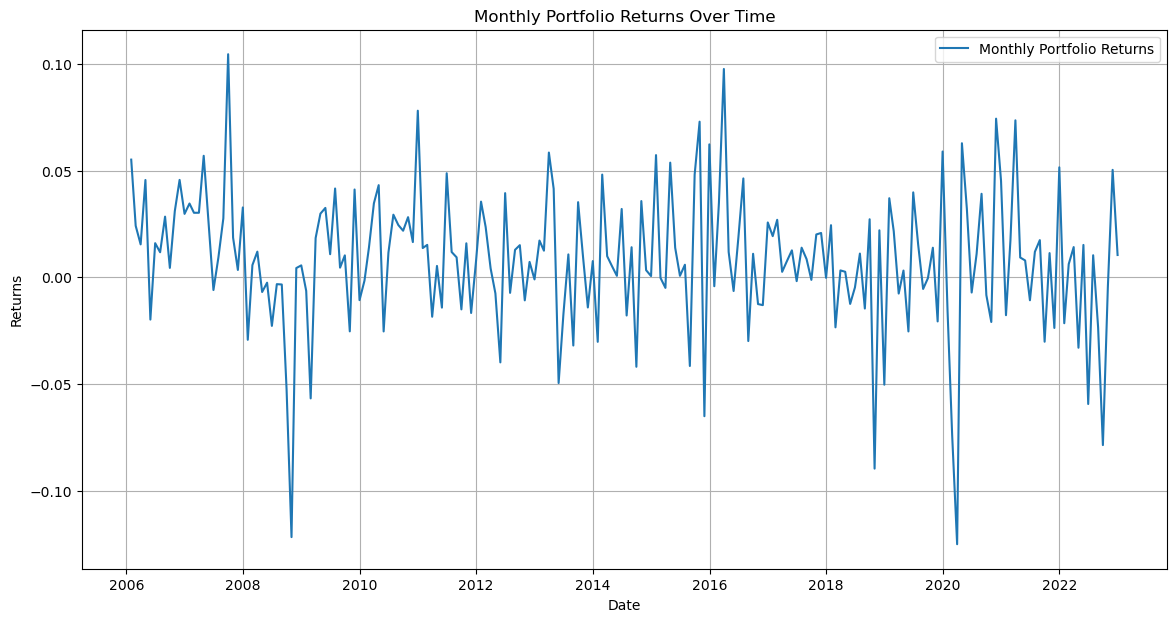

In [75]:
import matplotlib.pyplot as plt

# Make sure you've calculated `portfolio_returns` as shown in the code above

# Plotting the monthly portfolio returns
plt.figure(figsize=(14, 7))  # Set the figure size for better readability
plt.plot(portfolio_returns.index, portfolio_returns, label='Monthly Portfolio Returns')
plt.title('Monthly Portfolio Returns Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Returns')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Turn on the grid lines
plt.show()  # Display the plot


# 1.2 Benchmark comparison

In [76]:
# Load market caps data
market_caps_df = pd.read_excel(r'C:\Users\marko\OneDrive\Bureau\Marko_documents\Etudes\Master_1ère\2ème_semestre\Sustainability Aware Asset Management\Data (1)\DS_MV_USD_M.xlsx', header=None).T
market_caps_df.columns = market_caps_df.iloc[0]
market_caps_df = market_caps_df.drop(columns=list(dropped_stocks), errors='ignore')
market_caps_df.columns = market_caps_df.iloc[1]
market_caps_df = market_caps_df.drop([0, 1])
market_caps_df = market_caps_df.rename(columns={market_caps_df.columns[0]: "Date"}).set_index("Date")
market_caps_df = market_caps_df.astype(float)
market_caps_df = apply_column_names(market_caps_df, column_names)
market_caps_df

,SCHLUMBERGER,ALUAR,BBVA BANCO FRANCES,TERNIUM ARGENTINA SOCIEDAD ANONIMA,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,...,AEON FINANCIAL SERVICE,IHI,ISUZU MOTORS,ITO EN,ITOCHU,ITOCHU TECHNO-SOLUTIONS,IBIDEN,USHIO,UBE,EISAI
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,33574.85,1328.64,1407.47,567.85,2583.84,1655.07,1386.43,1065.59,644.41,208.32,...,908.82,12.14,279.60,2881.70,2498.08,1059.00,459.38,259.71,445.83,1350.98
2000-02-29,40611.13,1395.07,1463.08,559.05,2113.74,1781.21,1283.95,1016.74,659.49,142.46,...,765.96,9.79,229.02,2349.45,2370.64,713.59,472.66,207.52,454.09,1319.65
2000-03-31,43352.43,1362.23,1460.01,576.48,2065.10,1618.73,1428.44,1026.40,604.19,140.80,...,771.29,8.86,171.79,2285.60,2209.70,690.02,389.46,249.66,389.04,1182.07
2000-04-30,43387.86,1340.19,1356.04,498.86,2223.10,1446.45,1487.43,944.30,567.35,124.30,...,747.79,9.77,178.61,2089.92,2134.90,571.00,339.13,193.50,351.95,1186.24
2000-05-31,41861.39,1317.78,893.05,517.64,2305.32,1554.72,1567.26,912.06,567.61,105.33,...,749.57,9.81,144.05,2206.31,1870.46,578.02,330.23,206.19,276.11,950.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,53958.90,2911.44,5673.71,2778.87,13255.37,16321.45,2703.34,3612.25,2996.46,988.76,...,3114.48,437.80,233.53,9002.95,4291.26,339.86,232.46,3751.06,119.12,96.41
2022-09-30,50906.19,2584.93,5021.04,2719.75,11981.47,14584.20,2324.62,3062.82,2586.32,772.08,...,3056.65,352.27,152.43,8048.13,3721.10,281.15,197.11,3460.91,102.86,71.07
2022-10-31,73778.56,2574.33,5110.32,2739.62,15085.69,13333.42,2634.32,3878.67,2846.36,657.29,...,3162.15,393.50,114.95,8727.50,3934.23,291.67,188.54,3720.23,107.07,70.63


In [77]:
value_weighted_returns = pd.Series(index=portfolio_returns.index, dtype=float)
for date in portfolio_returns.index:
    if date in market_caps_df.index:
        weights = market_caps_df.loc[date] / market_caps_df.loc[date].sum()
        value_weighted_returns.loc[date] = (weights * monthly_returns.loc[date]).sum()
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
benchmark_cumulative_returns = (1 + value_weighted_returns).cumprod() - 1


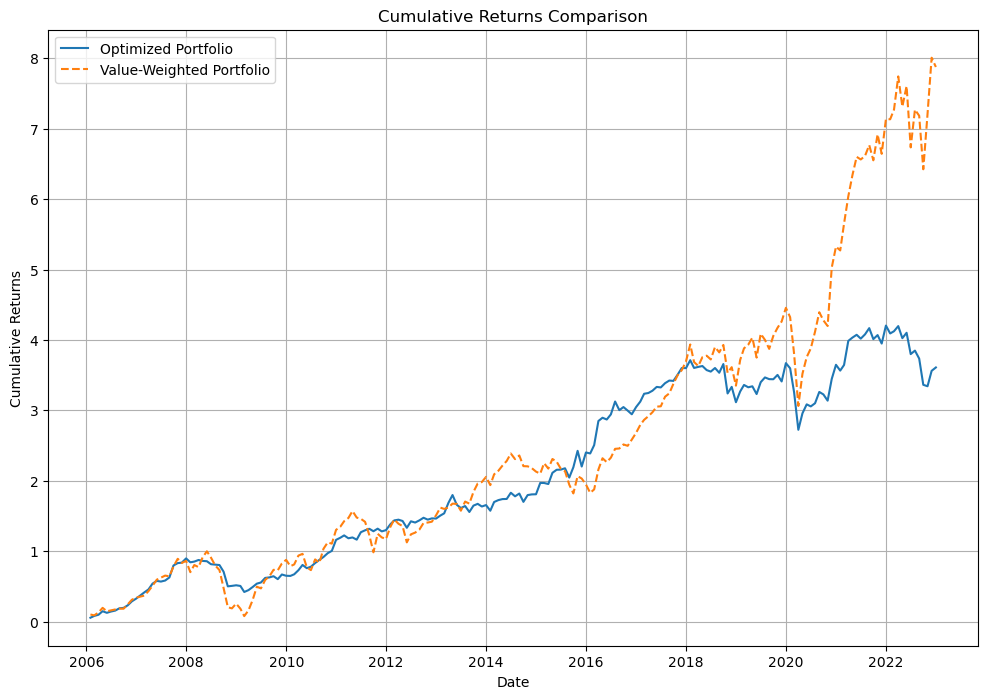

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns.index, cumulative_returns, label='Optimized Portfolio')
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Value-Weighted Portfolio', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [79]:
# Compute performance metrics for cf
annual_returns = portfolio_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return = annual_returns.mean()
annualized_volatility = annual_returns.std() * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility
cumulative_returns = (1 + portfolio_returns.fillna(0)).cumprod()
peak = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

# Compute performance metrics for cf
annual_returns_vw = value_weighted_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return_vw = annual_returns_vw.mean()
annualized_volatility_vw = annual_returns_vw.std() * np.sqrt(12)
sharpe_ratio_vw = annualized_return_vw / annualized_volatility_vw
cumulative_returns_vw = (1 + value_weighted_returns.fillna(0)).cumprod()
peak_vw = cumulative_returns_vw.expanding(min_periods=1).max()
drawdown_vw = (cumulative_returns_vw - peak_vw) / peak_vw
max_drawdown_vw = drawdown_vw.min()


stats = pd.DataFrame({
    'Annualized Returns': [annualized_return, annualized_return_vw],
    'Annualized Volatilities': [annualized_volatility, annualized_volatility_vw],
    'Sharpe Ratio': [
        sharpe_ratio,
        sharpe_ratio_vw
    ],
    'Max Drawdown': [
        max_drawdown,
        max_drawdown_vw
    ], 
    'Max returns': [portfolio_returns.max(), value_weighted_returns.max()], 
    'Min returns': [portfolio_returns.min(), value_weighted_returns.min()]
}, index=['MVP Portfolio', 'Value Weighted Portfolio'])
print(stats)

                          Annualized Returns  Annualized Volatilities  \
MVP Portfolio                       0.105435                 0.562081   
Value Weighted Portfolio            0.155874                 0.703389   

                          Sharpe Ratio  Max Drawdown  Max returns  Min returns  
MVP Portfolio                 0.187581     -0.251175     0.104632    -0.125107  
Value Weighted Portfolio      0.221604     -0.460543     0.159559    -0.185110  


# Part 2

# Part 2.1

In [80]:
import pandas as pd
import numpy as np

# Assuming the CSV file is saved in the same directory as your script, or provide the full path
file_path = 'portfolio_returns_hp.csv'
portfolio_returns_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)  # Assuming 'Date' is the column for dates
portfolio_returns_df.dropna(inplace=True)
portfolio_returns = pd.Series(portfolio_returns_df['Returns'], dtype=float, index=portfolio_returns_df.index)
# Check the first few rows to ensure it's loaded correctly
print(portfolio_returns)


Date
2006-01-31    0.055217
2006-02-28    0.024178
2006-03-31    0.015482
2006-04-30    0.045664
2006-05-31   -0.019783
                ...   
2022-08-31   -0.023406
2022-09-30   -0.078631
2022-10-31   -0.004662
2022-11-30    0.050419
2022-12-31    0.010493
Name: Returns, Length: 204, dtype: float64


In [81]:
import pandas as pd
import numpy as np

# File paths
file_paths_intensity  = [
    r"Data (1)\TC_Scope1Intensity.xlsx",
    r"Data (1)\TC_Scope2Intensity.xlsx",
    r"Data (1)\TC_Scope3Intensity.xlsx"
]

cleaned_dfs_intensity = [clean_and_handle_missing_values(file_path) for file_path in file_paths_intensity]
combined_carbon_intensity = cleaned_dfs_intensity[0] + cleaned_dfs_intensity[1] + cleaned_dfs_intensity[2]
# combined_carbon_intensity_sum = combined_carbon_intensity.groupby(level=0, axis=1).sum()

combined_carbon_intensity


C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)
C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', axis=0, inplace=True)
C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)
C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', axis=0

,SCHLUMBERGER,ALUAR,BBVA BANCO FRANCES,TERNIUM ARGENTINA SOCIEDAD ANONIMA,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,...,AEON FINANCIAL SERVICE,IHI,ISUZU MOTORS,ITO EN,ITOCHU,ITOCHU TECHNO-SOLUTIONS,IBIDEN,USHIO,UBE,EISAI
Date,,,,,,,,,,,,,,,,,,,,,
2005,442.285565,2126.315921,5300.103494,141.699601,1004.631748,1471.414508,732.678050,3516.037515,1196.507639,6882.181475,...,1306.303668,810.936495,603.706434,863.728832,252.075969,5300.103494,8938.627639,863.728832,828.722560,1088.033856
2006,379.073168,1840.714061,4662.568618,131.103787,1055.681555,1177.764618,966.827973,3110.929381,1145.257445,6081.528963,...,1123.223473,505.667898,541.313315,730.891960,240.132885,4662.568618,9186.552254,730.891960,714.731462,1015.423615
2007,382.219763,1764.559425,4110.402222,124.563393,892.832565,963.512909,905.642730,2705.663346,1104.739128,4890.224116,...,897.737400,443.439113,619.429312,1154.689956,219.222652,4611.506619,8713.626454,630.001403,599.026301,941.335088
2008,339.962406,1609.940029,3700.705260,125.327022,661.338708,666.401141,795.614468,2735.256982,1042.592983,5557.883333,...,786.865648,414.047807,481.613732,896.485746,184.779629,4457.086237,8109.250187,1578.477628,533.757446,874.237285
2009,324.068369,1741.989234,3956.875447,131.841662,865.015735,569.759265,796.477718,2274.354625,1064.446077,4342.433648,...,2155.612239,392.530971,639.690385,1340.339812,215.614102,5062.733502,6769.027772,2041.905467,517.803387,912.250463
2010,326.588885,1722.162685,3556.551451,127.549788,756.211301,882.336681,1109.654702,2146.104261,1036.953209,4027.869296,...,1885.398975,137.362903,522.929006,1349.353070,205.004960,4642.881908,6696.595822,1494.361793,450.870449,934.154375
2011,307.375645,1668.973680,3979.795494,121.961738,587.817202,995.211962,963.046568,2414.918191,968.655670,3447.400271,...,1046.958142,136.913006,357.079757,1037.812984,186.053123,4308.537346,6366.971980,1440.982950,498.515034,920.953265
2012,306.074613,1411.343536,3191.473818,118.432382,537.890534,1115.728269,780.136927,1876.508585,956.934125,3315.112712,...,1002.825657,155.255314,428.501480,1298.464261,186.001725,4640.500212,6563.574192,1507.679081,433.830816,807.638636
2013,286.260868,1832.120081,3143.601711,116.666784,564.050910,979.703083,698.889208,1437.563975,942.406348,3304.745215,...,897.221110,188.952286,372.743373,1237.669724,181.748361,5025.781735,6467.479235,1361.235401,389.824402,888.382391


In [82]:
# File paths
file_paths_emissions  = [
    r"Data (1)\TC_Scope1.xlsx",
    r"Data (1)\TC_Scope2.xlsx",
    r"Data (1)\TC_Scope3.xlsx"
]

cleaned_dfs_emissions = [clean_and_handle_missing_values(file_path) for file_path in file_paths_emissions]
combined_carbon_emissions = cleaned_dfs_emissions[0] + cleaned_dfs_emissions[1] + cleaned_dfs_emissions[2]
combined_carbon_emissions_sum = combined_carbon_intensity.groupby(level=0, axis=1).sum()

combined_carbon_emissions

C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)
C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', axis=0, inplace=True)
C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)
C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', axis=0

,SCHLUMBERGER,ALUAR,BBVA BANCO FRANCES,TERNIUM ARGENTINA SOCIEDAD ANONIMA,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,...,AEON FINANCIAL SERVICE,IHI,ISUZU MOTORS,ITO EN,ITOCHU,ITOCHU TECHNO-SOLUTIONS,IBIDEN,USHIO,UBE,EISAI
Date,,,,,,,,,,,,,,,,,,,,,
2005,6.328664e+06,1.268922e+06,7.706032e+06,68586.415832,1.846260e+07,4.350753e+06,1.689241e+06,2.640671e+07,2.055684e+06,3.621418e+06,...,1.078275e+06,9.531180e+05,9.715689e+05,1.623075e+06,2.372513e+06,2.009677e+07,5.583782e+06,2.020607e+05,1.688008e+06,2.665487e+06
2006,7.289758e+06,1.155913e+06,7.720561e+06,80195.820237,2.640776e+07,4.472078e+06,2.836677e+06,2.447667e+07,2.285224e+06,3.792614e+06,...,7.242882e+05,9.010496e+05,9.001824e+05,1.793492e+06,2.588835e+06,1.684805e+07,5.552352e+06,2.433286e+05,1.600777e+06,1.998689e+06
2007,8.896754e+06,1.511257e+06,8.293887e+06,94960.902298,2.612283e+07,4.273623e+06,3.275293e+06,2.550055e+07,2.801353e+06,3.810932e+06,...,7.829238e+05,1.103729e+06,1.569436e+06,5.153173e+06,2.972688e+06,1.971548e+07,7.051415e+06,3.340015e+05,1.876090e+06,2.335296e+06
2008,9.234399e+06,1.623753e+06,8.724034e+06,95476.631628,2.352693e+07,3.475595e+06,2.694221e+06,4.976417e+07,2.508937e+06,3.910787e+06,...,1.267457e+06,1.492833e+06,1.718889e+06,4.314768e+06,2.611768e+06,1.901219e+07,6.078085e+06,7.848033e+05,2.022855e+06,1.932553e+06
2009,7.357000e+06,1.519119e+06,6.639795e+06,94899.628137,2.223679e+07,2.847294e+06,2.076234e+06,3.732586e+07,2.445820e+06,3.846787e+06,...,2.817584e+06,1.476148e+06,2.796692e+06,4.533632e+06,3.193144e+06,1.759918e+07,6.153693e+06,8.424289e+05,2.264432e+06,2.357939e+06
2010,8.963885e+06,1.695092e+06,8.682574e+06,90101.807777,2.333923e+07,3.862227e+06,2.561957e+06,2.590385e+07,2.440951e+06,3.953953e+06,...,3.042791e+06,5.670360e+05,2.201657e+06,4.522854e+06,3.213461e+06,1.917928e+07,6.110267e+06,7.765678e+05,2.018171e+06,2.320197e+06
2011,1.215363e+07,1.944837e+06,1.170569e+07,106813.680450,2.783824e+07,5.349946e+06,2.710410e+06,3.492780e+07,2.639818e+06,3.913679e+06,...,2.226178e+06,6.767818e+05,1.556716e+06,4.909257e+06,3.147323e+06,1.866723e+07,6.243231e+06,7.346890e+05,2.442981e+06,2.092743e+06
2012,1.290074e+07,1.948633e+06,8.648908e+06,92407.691672,2.946651e+07,4.549223e+06,2.429021e+06,3.327896e+07,2.399218e+06,4.044934e+06,...,2.509895e+06,6.667831e+05,1.950312e+06,4.605801e+06,3.192888e+06,1.768623e+07,5.980308e+06,7.140107e+05,2.532437e+06,2.205238e+06
2013,1.295788e+07,2.190912e+06,9.156222e+06,96365.213809,3.176201e+07,4.138063e+06,2.470830e+06,2.617018e+07,2.501561e+06,3.913859e+06,...,1.772625e+06,6.508097e+05,1.457424e+06,4.202947e+06,3.152631e+06,1.746090e+07,5.793779e+06,7.158492e+05,2.279069e+06,1.750893e+06


50th Percentile: Number of firms below: 417, Intensity value: 529.95
75th Percentile: Number of firms below: 625, Intensity value: 1100.61
80th Percentile: Number of firms below: 666, Intensity value: 1385.80
90th Percentile: Number of firms below: 749, Intensity value: 2989.30
95th Percentile: Number of firms below: 791, Intensity value: 4727.75
100th Percentile: Number of firms below: 833, Intensity value: 21615.14


c:\Users\marko\anaconda3\envs\master\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


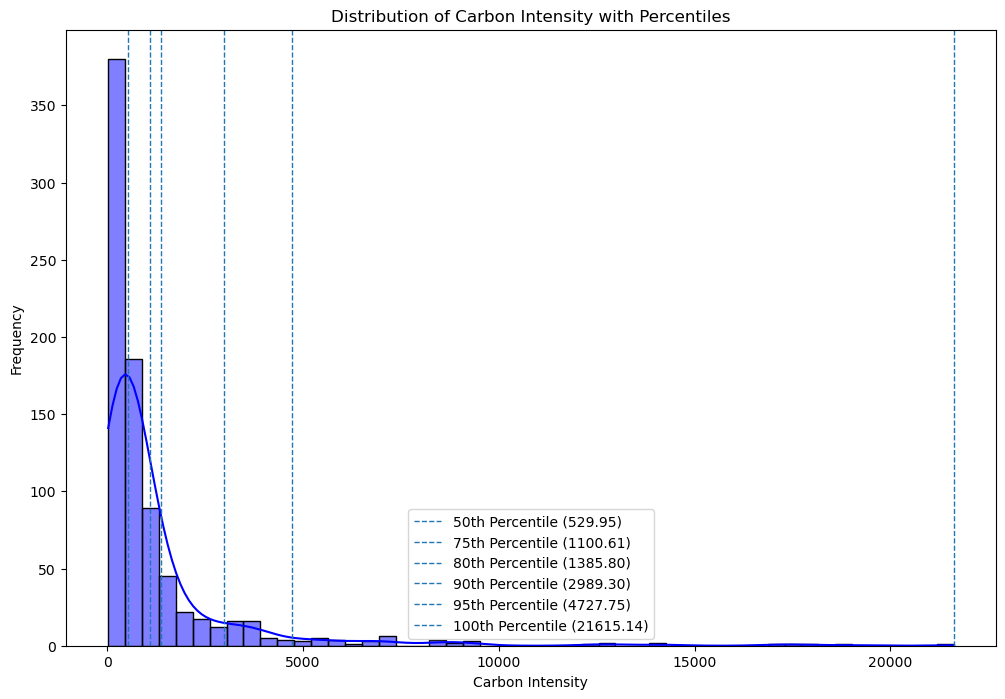

In [83]:
# Calculate carbon intensity for visualization
carbon_intensity = combined_carbon_intensity.mean(axis=0)  # Average over time

# Percentile values
percentiles = [50, 75, 80, 90, 95, 100]
percentile_values = np.percentile(carbon_intensity, percentiles)

# Number of firms in each percentile range and intensity values
num_firms = [(carbon_intensity <= p).sum() for p in percentile_values]
intensity_values = [np.percentile(carbon_intensity, p) for p in percentiles]

# Print number of firms and intensity values in each percentile range
for p, n, iv in zip(percentiles, num_firms, intensity_values):
    print(f"{p}th Percentile: Number of firms below: {n}, Intensity value: {iv:.2f}")

# Plot percentiles of carbon intensity
plt.figure(figsize=(12, 8))
sns.histplot(carbon_intensity, kde=True, bins=50, color='blue')
for p, v in zip(percentiles, percentile_values):
    plt.axvline(v, linestyle='dashed', linewidth=1, label=f'{p}th Percentile ({v:.2f})')

plt.title('Distribution of Carbon Intensity with Percentiles')
plt.xlabel('Carbon Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [84]:
cap_y = clean_and_handle_missing_values(r"C:\Users\marko\OneDrive\Bureau\Marko_documents\Etudes\Master_1ère\2ème_semestre\Sustainability Aware Asset Management\Data (1)\DS_MV_USD_Y_CAI.xlsx")

cap_y = cap_y[:-1]

cap_y

C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)
C:\Users\marko\AppData\Local\Temp\ipykernel_74616\1303011273.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', axis=0, inplace=True)


,SCHLUMBERGER,ALUAR,BBVA BANCO FRANCES,TERNIUM ARGENTINA SOCIEDAD ANONIMA,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,...,AEON FINANCIAL SERVICE,IHI,ISUZU MOTORS,ITO EN,ITOCHU,ITOCHU TECHNO-SOLUTIONS,IBIDEN,USHIO,UBE,EISAI
Date,,,,,,,,,,,,,,,,,,,,,
2005,57229.88,1465.58,2922.13,1498.41,17516.73,5367.35,2957.05,3977.46,1670.28,835.16,...,1356.28,927.98,1025.63,9854.76,4701.42,4304.66,2600.11,698.65,1123.63,1729.95
2006,74415.94,1799.46,2765.02,2060.23,17006.48,8049.10,4400.99,8933.41,2246.94,1200.79,...,2985.90,1036.85,1887.58,14484.95,6183.09,6211.41,2958.45,1724.04,1887.81,2015.96
2007,117637.40,2472.38,2702.53,2425.45,24307.14,10571.30,4655.19,11888.23,2384.63,1659.21,...,4683.57,1627.58,4953.36,21901.26,5831.70,8902.86,3439.16,1395.91,3523.85,2063.64
2008,50633.77,1051.19,1378.51,926.84,7806.73,6835.27,1388.67,3441.26,1551.42,808.90,...,2540.88,791.85,1723.18,9222.61,3776.21,4264.67,1987.72,801.53,1299.61,939.69
2009,78157.75,1973.17,2203.12,1048.49,13213.70,6437.19,2154.93,6199.15,2272.58,1568.35,...,5008.47,1118.85,2094.90,17410.15,6098.47,5611.44,2764.58,2351.06,2145.73,1356.21
2010,113925.60,2670.88,3053.02,1443.25,12516.44,6367.03,2253.04,8084.84,2335.87,2148.43,...,6759.99,1331.88,2015.20,22244.49,7756.01,4803.88,3096.65,2473.64,2577.49,2296.07
2011,91680.50,1512.32,1816.46,797.25,9958.36,4582.16,1063.23,4755.46,1700.82,1885.18,...,4527.07,1038.22,1054.45,13094.48,6283.99,3786.46,1988.65,1421.02,1641.48,1950.54
2012,92046.13,1230.68,1451.79,1190.28,11803.41,4210.55,1073.66,6288.89,2132.71,2064.60,...,4823.89,1120.25,1297.35,12486.25,8323.92,1891.36,2440.24,1713.53,1408.75,2615.42
2013,117803.40,1442.16,2113.70,1765.22,15689.64,3639.54,1866.50,8300.58,2480.40,2096.27,...,3906.02,1607.78,1138.41,7424.50,8402.60,1587.45,1814.91,1534.18,984.11,2732.60


In [86]:
optimal_weights_annual_df = pd.read_csv('C:\\Users\\marko\\OneDrive\\Bureau\\Marko_documents\\Etudes\\Master_1ère\\2ème_semestre\\Sustainability Aware Asset Management\\annual_optimal_weights_hp.csv')
optimal_weights_annual_df = optimal_weights_annual_df.drop(optimal_weights_annual_df.columns[0], axis=1)
optimal_weights_annual_df.columns = combined_carbon_intensity.columns
optimal_weights_annual_df.index = combined_carbon_intensity.index

optimal_weights_annual_df

,SCHLUMBERGER,ALUAR,BBVA BANCO FRANCES,TERNIUM ARGENTINA SOCIEDAD ANONIMA,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,...,AEON FINANCIAL SERVICE,IHI,ISUZU MOTORS,ITO EN,ITOCHU,ITOCHU TECHNO-SOLUTIONS,IBIDEN,USHIO,UBE,EISAI
Date,,,,,,,,,,,,,,,,,,,,,
2005,9.057523e-18,1.391430e-02,1.130752e-03,1.550467e-18,9.281256e-19,0.000000e+00,1.041860e-18,0.000000e+00,0.000000e+00,1.416652e-03,...,5.510590e-19,1.387943e-19,0.000000e+00,1.523954e-19,2.170767e-18,2.764737e-18,2.926861e-20,0.000000e+00,9.999059e-19,0.000000e+00
2006,1.111042e-18,7.580639e-03,0.000000e+00,4.869235e-19,0.000000e+00,1.035517e-18,8.958056e-19,0.000000e+00,0.000000e+00,3.486291e-18,...,9.270306e-20,1.161843e-18,0.000000e+00,0.000000e+00,6.098771e-19,1.915547e-18,0.000000e+00,0.000000e+00,7.719209e-20,9.702227e-20
2007,0.000000e+00,3.829778e-03,0.000000e+00,1.234784e-18,0.000000e+00,4.850856e-18,0.000000e+00,5.184510e-18,0.000000e+00,7.090547e-18,...,8.171679e-19,0.000000e+00,9.193207e-20,0.000000e+00,0.000000e+00,1.810563e-18,2.188052e-19,1.471117e-19,1.530036e-18,0.000000e+00
2008,1.028004e-17,0.000000e+00,0.000000e+00,1.686027e-18,3.359866e-18,0.000000e+00,1.227944e-18,4.197819e-19,0.000000e+00,7.147890e-19,...,0.000000e+00,1.149351e-18,0.000000e+00,3.655376e-18,0.000000e+00,5.176504e-20,6.988336e-19,0.000000e+00,0.000000e+00,0.000000e+00
2009,0.000000e+00,0.000000e+00,4.384033e-18,0.000000e+00,1.067485e-20,1.956609e-18,1.750619e-18,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.233585e-19,1.173618e-18,0.000000e+00,0.000000e+00,0.000000e+00,1.754938e-18,4.637189e-19,1.411361e-18,0.000000e+00
2010,9.119254e-20,9.833441e-19,0.000000e+00,3.316692e-18,0.000000e+00,0.000000e+00,0.000000e+00,1.071957e-18,0.000000e+00,0.000000e+00,...,0.000000e+00,7.857816e-19,6.578562e-19,1.930885e-18,3.711589e-19,1.017342e-18,0.000000e+00,1.132208e-18,0.000000e+00,0.000000e+00
2011,3.923170e-18,0.000000e+00,0.000000e+00,1.882248e-18,0.000000e+00,0.000000e+00,1.793320e-18,4.914858e-18,0.000000e+00,0.000000e+00,...,2.773021e-18,3.283872e-19,0.000000e+00,1.147629e-18,1.050335e-18,0.000000e+00,8.068145e-19,2.527225e-19,0.000000e+00,0.000000e+00
2012,0.000000e+00,3.749557e-18,0.000000e+00,0.000000e+00,1.567416e-18,9.045862e-19,2.949824e-18,0.000000e+00,0.000000e+00,1.912663e-18,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.105607e-18,3.554820e-19,1.787661e-19,3.833744e-19,0.000000e+00,5.143842e-19
2013,2.820351e-18,4.770136e-18,0.000000e+00,4.993733e-18,7.215447e-18,6.165091e-18,6.355843e-18,6.641544e-18,2.527522e-18,0.000000e+00,...,2.412457e-18,1.446915e-18,0.000000e+00,2.848722e-18,1.788295e-18,3.007083e-19,1.040478e-18,2.138588e-19,0.000000e+00,0.000000e+00


# WACI

In [88]:
def calculate_waci(weights_df, ci_df):
    waci = weights_df.multiply(ci_df).sum(axis=1)  # Sum across firms for each year
    return waci

waci = calculate_waci(optimal_weights_annual_df, carbon_intensity)
print(waci)


Date
2005    1985.608565
2006    1965.850097
2007    1638.589212
2008    1684.890984
2009    1960.893793
2010    2166.981758
2011    2250.579413
2012    2181.855059
2013    2436.599510
2014    3200.261587
2015    1931.166554
2016    1883.832078
2017    1888.241250
2018    1468.068815
2019    2411.124332
2020    2388.153648
2021    1963.281761
dtype: float64


# CF

In [389]:
cap_y = clean_and_handle_missing_values(r"C:\Users\marko\OneDrive\Bureau\Marko_documents\Etudes\Master_1ère\2ème_semestre\Sustainability Aware Asset Management\Data (1)\DS_MV_USD_Y_CAI.xlsx")

cap_y = cap_y[:-1]

cap_y

C:\Users\marko\AppData\Local\Temp\ipykernel_3292\1303011273.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)
C:\Users\marko\AppData\Local\Temp\ipykernel_3292\1303011273.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', axis=0, inplace=True)


,SCHLUMBERGER,ALUAR,BBVA BANCO FRANCES,TERNIUM ARGENTINA SOCIEDAD ANONIMA,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,...,HARMONY GOLD MNG.,GOLD FIELDS,DISCOVERY,BARLOWORLD,TRUWORTHS INTL.,MTN GROUP,AFRICAN RAINBOW MINERALS,REUNERT,WOOLWORTHS HDG.,FIRSTRAND
Date,,,,,,,,,,,,,,,,,,,,,
2005,57229.88,1465.58,1133.92,2922.13,1498.41,13399.87,17516.73,5367.35,2957.05,6174.20,...,16164.59,4701.42,4304.66,2600.11,1219.13,360.05,10619.19,698.65,1123.63,1729.95
2006,74415.94,1799.46,1475.76,2765.02,2060.23,24155.57,17006.48,8049.10,4400.99,7365.86,...,18256.70,6183.09,6211.41,2958.45,1694.37,486.51,11922.32,1724.04,1887.81,2015.96
2007,117637.40,2472.38,1264.44,2702.53,2425.45,22427.02,24307.14,10571.30,4655.19,8443.02,...,20099.86,5831.70,8902.86,3439.16,2923.83,689.60,11021.03,1395.91,3523.85,2063.64
2008,50633.77,1051.19,518.69,1378.51,926.84,7138.94,7806.73,6835.27,1388.67,4291.70,...,13691.24,3776.21,4264.67,1987.72,2286.13,256.49,7958.04,801.53,1299.61,939.69
2009,78157.75,1973.17,1143.00,2203.12,1048.49,14115.54,13213.70,6437.19,2154.93,6611.16,...,21584.39,6098.47,5611.44,2764.58,2940.05,395.80,12532.99,2351.06,2145.73,1356.21
2010,113925.60,2670.88,2072.78,3053.02,1443.25,17827.72,12516.44,6367.03,2253.04,6678.87,...,25767.39,7756.01,4803.88,3096.65,4354.14,423.27,15198.47,2473.64,2577.49,2296.07
2011,91680.50,1512.32,990.72,1816.46,797.25,6891.26,9958.36,4582.16,1063.23,5087.87,...,19432.73,6283.99,3786.46,1988.65,3909.16,299.60,12543.32,1421.02,1641.48,1950.54
2012,92046.13,1230.68,1254.71,1451.79,1190.28,12498.19,11803.41,4210.55,1073.66,6813.71,...,22504.49,8323.92,1891.36,2440.24,5104.21,260.92,13882.69,1713.53,1408.75,2615.42
2013,117803.40,1442.16,1674.58,2113.70,1765.22,15002.04,15689.64,3639.54,1866.50,6389.51,...,19991.08,8402.60,1587.45,1814.91,4487.91,239.61,10704.38,1534.18,984.11,2732.60


In [89]:

V2005 = 1e6  # Initial portfolio value in USD

def calculate_cf(weights_df, cap_y_df, VY):
    vi_y = weights_df * VY  # Dollar value invested per firm
    oi_y = vi_y.div(cap_y_df)  # Fraction of equity owned
    cf = oi_y.multiply(combined_carbon_emissions).sum(axis=1) / VY  # Sum across all firms for each year, assuming CI approximates emissions
    return cf

cf = calculate_cf(optimal_weights_annual_df, cap_y, V2005)  # Assuming V2005 constant or adjust dynamically

print(cf)

Date
2005    2294.113818
2006    1918.716846
2007    1149.012491
2008    1503.547602
2009    1505.398305
2010    1309.540402
2011    1492.514462
2012    1514.353475
2013    2223.421905
2014    4796.158677
2015    1426.028580
2016    3892.348107
2017    8027.000595
2018    1033.270355
2019    9007.804348
2020    4649.428996
2021    2671.357619
dtype: float64


# Part 2.2

In [90]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
from tqdm import tqdm

# Assuming returns, combined_carbon_emissions, and cap_y are loaded appropriately
returns = monthly_returns.values
dates = monthly_returns.index

# Define the objective function
def objective(weights, cov_matrix):
    return np.dot(weights, np.dot(cov_matrix, weights))

# Calculate the baseline carbon footprint from the provided data
def calculate_baseline_cf(weights, emissions, cap, total_value):
    ownership = weights * total_value / cap
    cf = (ownership * emissions).sum() / total_value
    return cf

# Optimization with carbon footprint constraint
def optimize_portfolio_with_cf(returns, num_assets, baseline_cf, reduction_factor, emissions_year, cap_year):
    # Calculate covariance matrix
    cov_matrix = np.cov(returns, rowvar=False)
    initial_weights = np.full(num_assets, 1.0 / num_assets)

    # Define additional constraints for carbon footprint
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
                   {'type': 'ineq', 'fun': lambda w: baseline_cf * reduction_factor - calculate_baseline_cf(w, emissions_year, cap_year, V2005)}]
    bounds = [(0, 1) for _ in range(returns.shape[1])]  # Non-negative weights
    
    result = sco.minimize(lambda w: objective(w, cov_matrix),
                          initial_weights, method='SLSQP', bounds=bounds,
                          constraints=constraints)
    return result.x

# Update weights function without Numba
def update_weights(weights, returns, portfolio_return):
    new_weights = weights * (1 + returns) / (1 + portfolio_return)
    return new_weights / np.sum(new_weights)

# Define the optimization and rebalance logic with the new constraints
start_year = 1999
end_year = 2021

# Initialize an empty dictionary to store the baseline carbon footprint for each year
baseline_cf_yearly = {}

# Calculate baseline CF for each year
for year in range(start_year, end_year - 6 + 1):
    emissions_year = combined_carbon_emissions.loc[year + 6]
    cap_year = cap_y.loc[year + 6]
    optimal_weights_yearly = optimal_weights_annual_df.loc[year + 6]
    baseline_cf_yearly[year + 6] = calculate_baseline_cf(optimal_weights_yearly, emissions_year, cap_year, V2005)

optimal_weights_annual_cf = {}
optimal_weights_monthly_cf = {}
portfolio_returns_cf = pd.Series(dtype=float, index=monthly_returns.index)

for year in tqdm(range(start_year, end_year - 6 + 1), desc="Calculating optimal weights"):
    # Similar rolling window approach, compute new weights with carbon constraints
    if year == start_year:
        start_index = ((year - start_year) * 12)
        end_index = start_index + (6 * 12) - 1
    else:
        start_index = ((year - start_year) * 12) - 1
        end_index = start_index + (6 * 12)

    if end_index < returns.shape[0]:
        train_returns_cf = returns[start_index:end_index]
        baseline_cf = baseline_cf_yearly[year + 6]

        emissions_year = combined_carbon_emissions.loc[year + 6]
        cap_year = cap_y.loc[year + 6]

        weights = optimize_portfolio_with_cf(train_returns_cf, returns.shape[1], baseline_cf, reduction_factor=0.5, emissions_year=emissions_year, cap_year=cap_year)
        optimal_weights_annual_cf[year + 6] = weights

        for month in range(12):
            month_idx = end_index + month
            if month_idx < returns.shape[0]:
                month_returns_cf = returns[month_idx]
                portfolio_return_cf = np.dot(month_returns_cf, weights)
                portfolio_returns_cf[dates[month_idx]] = portfolio_return_cf
                optimal_weights_monthly_cf[month_idx] = weights
                weights = update_weights(weights, month_returns_cf, portfolio_return_cf)


Calculating optimal weights: 100%|██████████| 17/17 [29:44<00:00, 104.99s/it]


In [91]:
# Save results

import pandas as pd

portfolio_returns_cf_df = pd.DataFrame(portfolio_returns_cf, index=dates, columns=['Returns'])
portfolio_returns_cf_df.to_csv('portfolio_returns_cf_hp.csv')

# Convert dictionary to DataFrame
optimal_weights_annual_cf_df = pd.DataFrame.from_dict(optimal_weights_annual_cf, orient='index')

# Save to CSV
optimal_weights_annual_cf_df.to_csv('annual_optimal_weights_cf_hp.csv')

# Monthly weights might require some transformation since they're indexed by months
optimal_weights_monthly_cf = pd.DataFrame.from_dict(optimal_weights_monthly_cf, orient='index')

# Save to CSV
optimal_weights_monthly_cf.to_csv('monthly_optimal_weights_cf_hp.csv')

In [95]:
import pandas as pd
import numpy as np

# Assuming the CSV file is saved in the same directory as your script, or provide the full path
file_path = 'portfolio_returns_cf_hp.csv'
portfolio_returns_cf_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)  # Assuming 'Date' is the column for dates
portfolio_returns_cf_df.dropna(inplace=True)
portfolio_returns_cf = pd.Series(portfolio_returns_cf_df['Returns'], dtype=float, index=portfolio_returns_cf_df.index)
# Check the first few rows to ensure it's loaded correctly
print(portfolio_returns_cf)

Date
2006-01-31    0.056943
2006-02-28    0.023979
2006-03-31    0.016452
2006-04-30    0.048328
2006-05-31   -0.022120
                ...   
2022-08-31   -0.023965
2022-09-30   -0.099401
2022-10-31    0.010720
2022-11-30    0.058333
2022-12-31   -0.001727
Name: Returns, Length: 204, dtype: float64


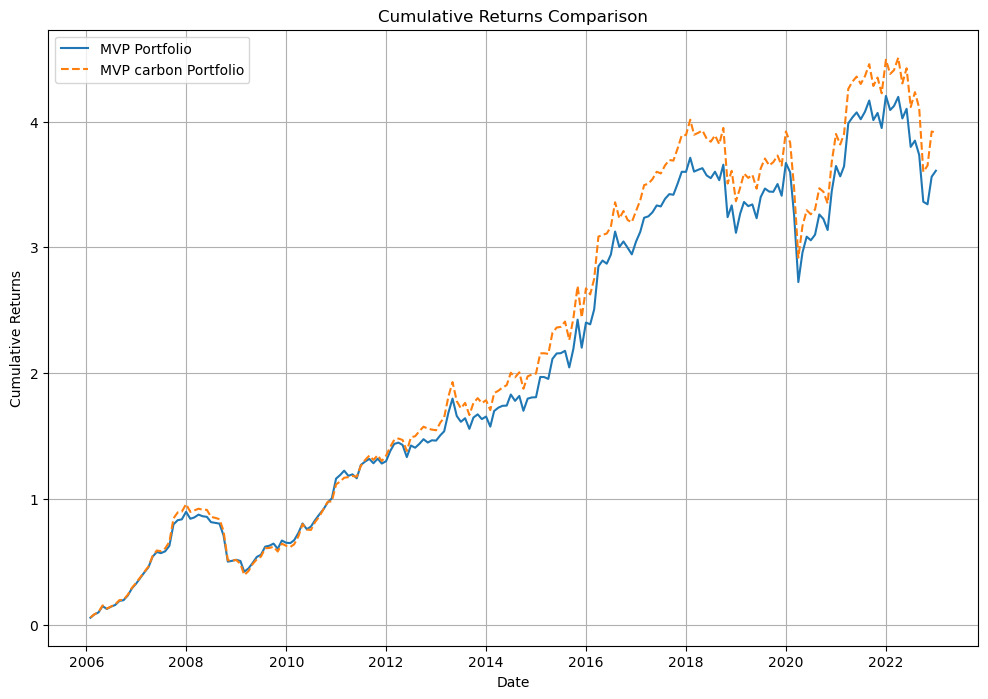

In [96]:
cumulative_returns_mv = (1 + portfolio_returns).cumprod() - 1
cumulative_returns_mv_cf = (1 + portfolio_returns_cf).cumprod() - 1


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns_mv.index, cumulative_returns_mv, label='MVP Portfolio')
plt.plot(cumulative_returns_mv_cf.index, cumulative_returns_mv_cf, label='MVP carbon Portfolio', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
# Compute performance metrics
annual_returns = portfolio_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return = annual_returns.mean()
annualized_volatility = annual_returns.std() * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility
cumulative_returns = (1 + portfolio_returns.fillna(0)).cumprod()
peak = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

# Compute performance metrics for cf
annual_returns_cf = portfolio_returns_cf.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return_cf = annual_returns_cf.mean()
annualized_volatility_cf = annual_returns_cf.std() * np.sqrt(12)
sharpe_ratio_cf = annualized_return_cf / annualized_volatility_cf
cumulative_returns_cf = (1 + portfolio_returns_cf.fillna(0)).cumprod()
peak_cf = cumulative_returns_cf.expanding(min_periods=1).max()
drawdown_cf = (cumulative_returns_cf - peak_cf) / peak_cf
max_drawdown_cf = drawdown_cf.min()


stats = pd.DataFrame({
    'Annualized Returns': [annualized_return, annualized_return_cf],
    'Annualized Volatilities': [annualized_volatility, annualized_volatility_cf],
    'Sharpe Ratio': [
        sharpe_ratio,
        sharpe_ratio_cf
    ],
    'Max Drawdown': [
        max_drawdown,
        max_drawdown_cf
    ], 
    'Max returns': [portfolio_returns.max(), portfolio_returns_cf.max()], 
    'Min returns': [portfolio_returns.min(), portfolio_returns_cf.min()]
}, index=['MVP Portfolio', 'MVP carbon Portfolio'])
print(stats)


                      Annualized Returns  Annualized Volatilities  \
MVP Portfolio                   0.105435                 0.562081   
MVP carbon Portfolio            0.110523                 0.585296   

                      Sharpe Ratio  Max Drawdown  Max returns  Min returns  
MVP Portfolio             0.187581     -0.251175     0.104632    -0.125107  
MVP carbon Portfolio      0.188832     -0.288016     0.112760    -0.133274  


# Part 2.3

In [98]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
from tqdm import tqdm

# Assuming returns, combined_carbon_emissions, and cap_y are loaded appropriately
returns = monthly_returns.values
dates = monthly_returns.index

# Define the objective function (tracking error)
def tracking_error(w, vw_w, cov_mat):
    return np.dot((w - vw_w), np.dot(cov_mat, (w - vw_w)))

# Calculate the baseline carbon footprint from the provided data
def calculate_baseline_cf(weights, emissions, cap, total_value):
    ownership = weights * total_value / cap
    cf = (ownership * emissions).sum() / total_value
    return cf

def optimize_portfolio_with_tracking_error(returns, num_assets, target_cf, vw_weights, emissions_year, cap_year):
    # Calculate covariance matrix
    cov_matrix = np.cov(returns, rowvar=False)
    initial_weights = np.full(num_assets, 1.0 / num_assets)

    # Define additional constraints for carbon footprint
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
                   {'type': 'ineq', 'fun': lambda w: target_cf - calculate_baseline_cf(w, emissions_year, cap_year, V2005)}]
    bounds = [(0, 1) for _ in range(num_assets)]  # Non-negative weights
    
    result = sco.minimize(lambda w: tracking_error(w, vw_weights, cov_matrix),
                          initial_weights, method='SLSQP', bounds=bounds,
                          constraints=constraints)
    return result.x

# Update weights function without Numba
def update_weights(weights, returns, portfolio_return):
    new_weights = weights * (1 + returns) / (1 + portfolio_return)
    return new_weights / np.sum(new_weights)


In [99]:
start_year = 1999
end_year = 2021

# Initialize dictionaries to store weights and returns
optimal_weights_annual_tracking_error = {}
optimal_weights_monthly_tracking_error = {}
portfolio_returns_tracking_error = pd.Series(dtype=float, index=monthly_returns.index)

for year in tqdm(range(start_year, end_year - 6 + 1), desc="Calculating optimal weights with tracking error"):
    if year == start_year:
        start_index = ((year - start_year) * 12)
        end_index = start_index + (6 * 12) - 1
    else:
        start_index = ((year - start_year) * 12) - 1
        end_index = start_index + (6 * 12)

    if end_index < returns.shape[0]:
        train_returns_te = returns[start_index:end_index]
        
        emissions_year = combined_carbon_emissions.loc[year + 6]
        cap_year = cap_y.loc[year + 6]
        
        # Calculate baseline carbon footprint for the value-weighted portfolio
        vw_weights = cap_year / cap_year.sum()
        vw_cf = calculate_baseline_cf(vw_weights, emissions_year, cap_year, V2005)
        
        # Set the target carbon footprint (50% reduction)
        target_cf = vw_cf * 0.5
        
        # Optimize portfolio with tracking error constraint
        weights = optimize_portfolio_with_tracking_error(train_returns_te, returns.shape[1], target_cf, vw_weights, emissions_year, cap_year)
        optimal_weights_annual_tracking_error[year + 6] = weights

        for month in range(12):
            month_idx = end_index + month
            if month_idx < returns.shape[0]:
                month_returns_te = returns[month_idx]
                portfolio_return_te = np.dot(month_returns_te, weights)
                portfolio_returns_tracking_error[dates[month_idx]] = portfolio_return_te
                optimal_weights_monthly_tracking_error[month_idx] = weights
                weights = update_weights(weights, month_returns_te, portfolio_return_te)




Calculating optimal weights with tracking error: 100%|██████████| 17/17 [06:43<00:00, 23.73s/it]


In [100]:
# Save results

import pandas as pd

portfolio_returns_te_df = pd.DataFrame(portfolio_returns_tracking_error, index=dates, columns=['Returns'])
portfolio_returns_te_df.to_csv('portfolio_returns_te_hp.csv')

# Convert dictionary to DataFrame
optimal_weights_annual_te_df = pd.DataFrame.from_dict(optimal_weights_annual_tracking_error, orient='index')

# Save to CSV
optimal_weights_annual_te_df.to_csv('annual_optimal_weights_te_hp.csv')

# Monthly weights might require some transformation since they're indexed by months
optimal_weights_monthly_te = pd.DataFrame.from_dict(optimal_weights_monthly_tracking_error, orient='index')

# Save to CSV
optimal_weights_monthly_te.to_csv('monthly_optimal_weights_te_hp.csv')

In [113]:
import pandas as pd
import numpy as np

# Assuming the CSV file is saved in the same directory as your script, or provide the full path
file_path = 'portfolio_returns_te_hp.csv'
portfolio_returns_tracking_error_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)  # Assuming 'Date' is the column for dates
portfolio_returns_tracking_error_df.dropna(inplace=True)
portfolio_returns_tracking_error = pd.Series(portfolio_returns_tracking_error_df['Returns'], dtype=float, index=portfolio_returns_tracking_error_df.index)
# Check the first few rows to ensure it's loaded correctly
print(portfolio_returns_tracking_error)

Date
2006-01-31    0.101090
2006-02-28   -0.003199
2006-03-31    0.042890
2006-04-30    0.062645
2006-05-31   -0.035212
                ...   
2022-08-31   -0.018100
2022-09-30   -0.098146
2022-10-31    0.074755
2022-11-30    0.085928
2022-12-31   -0.015945
Name: Returns, Length: 204, dtype: float64


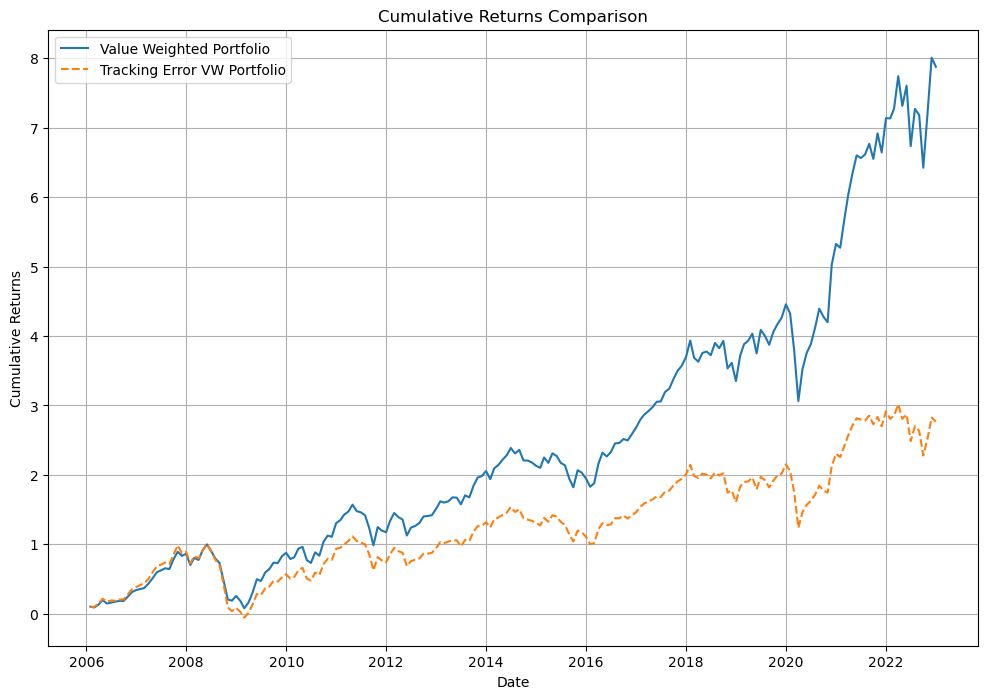

In [114]:
benchmark_cumulative_returns = (1 + value_weighted_returns).cumprod() - 1
benchmark_cumulative_returns_te = (1 + portfolio_returns_tracking_error).cumprod() - 1


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Value Weighted Portfolio')
plt.plot(benchmark_cumulative_returns_te.index, benchmark_cumulative_returns_te, label='Tracking Error VW Portfolio', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [115]:
# Compute performance metrics
annual_returns_vw = value_weighted_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return_vw = annual_returns_vw.mean()
annualized_volatility_vw = annual_returns_vw.std() * np.sqrt(12)
sharpe_ratio_vw = annualized_return_vw / annualized_volatility_vw
cumulative_returns_vw = (1 + value_weighted_returns.fillna(0)).cumprod()
peak_vw = cumulative_returns_vw.expanding(min_periods=1).max()
drawdown_vw = (cumulative_returns_vw - peak_vw) / peak_vw
max_drawdown_vw = drawdown_vw.min()

# Compute performance metrics for cf
annual_returns_te = portfolio_returns_tracking_error.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return_te = annual_returns_te.mean()
annualized_volatility_te = annual_returns_te.std() * np.sqrt(12)
sharpe_ratio_te = annualized_return_te / annualized_volatility_te
cumulative_returns_te = (1 + portfolio_returns_tracking_error.fillna(0)).cumprod()
peak_te = cumulative_returns_te.expanding(min_periods=1).max()
drawdown_te = (cumulative_returns_te - peak_te) / peak_te
max_drawdown_te = drawdown_te.min()


stats = pd.DataFrame({
    'Annualized Returns': [annualized_return_vw, annualized_return_te],
    'Annualized Volatilities': [annualized_volatility_vw, annualized_volatility_te],
    'Sharpe Ratio': [
        sharpe_ratio_vw,
        sharpe_ratio_te
    ],
    'Max Drawdown': [
        max_drawdown_vw,
        max_drawdown_te
    ], 
    'Max returns': [value_weighted_returns.max(), portfolio_returns_tracking_error.max()], 
    'Min returns': [value_weighted_returns.min(), portfolio_returns_tracking_error.min()]
}, index=['Value Weighted Portfolio', 'Tracking Error VW Portfolio'])
print(stats)


                             Annualized Returns  Annualized Volatilities  \
Value Weighted Portfolio               0.155874                 0.703389   
Tracking Error VW Portfolio            0.104917                 0.764729   

                             Sharpe Ratio  Max Drawdown  Max returns  \
Value Weighted Portfolio         0.221604     -0.460543     0.159559   
Tracking Error VW Portfolio      0.137194     -0.529423     0.138809   

                             Min returns  
Value Weighted Portfolio       -0.185110  
Tracking Error VW Portfolio    -0.233124  


# Part 2.4

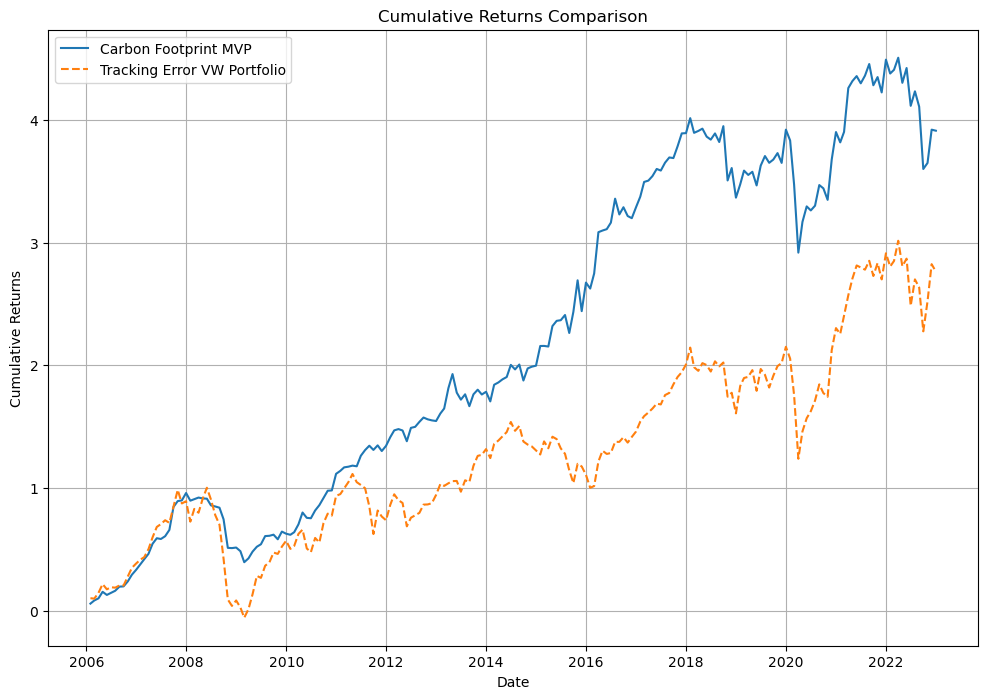

In [116]:
cumulative_returns_mv_cf = (1 + portfolio_returns_cf).cumprod() - 1
benchmark_cumulative_returns_te = (1 + portfolio_returns_tracking_error).cumprod() - 1


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns_mv_cf.index, cumulative_returns_mv_cf, label='Carbon Footprint MVP')
plt.plot(benchmark_cumulative_returns_te.index, benchmark_cumulative_returns_te, label='Tracking Error VW Portfolio', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [117]:
# Compute performance metrics for cf
annual_returns_cf = portfolio_returns_cf.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return_cf = annual_returns_cf.mean()
annualized_volatility_cf = annual_returns_cf.std() * np.sqrt(12)
sharpe_ratio_cf = annualized_return_cf / annualized_volatility_cf
cumulative_returns_cf = (1 + portfolio_returns_cf.fillna(0)).cumprod()
peak_cf = cumulative_returns_cf.expanding(min_periods=1).max()
drawdown_cf = (cumulative_returns_cf - peak_cf) / peak_cf
max_drawdown_cf = drawdown_cf.min()

# Compute performance metrics for cf
annual_returns_te = portfolio_returns_tracking_error.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return_te = annual_returns_te.mean()
annualized_volatility_te = annual_returns_te.std() * np.sqrt(12)
sharpe_ratio_te = annualized_return_te / annualized_volatility_te
cumulative_returns_te = (1 + portfolio_returns_tracking_error.fillna(0)).cumprod()
peak_te = cumulative_returns_te.expanding(min_periods=1).max()
drawdown_te = (cumulative_returns_te - peak_te) / peak_te
max_drawdown_te = drawdown_te.min()


stats = pd.DataFrame({
    'Annualized Returns': [annualized_return_cf, annualized_return_te],
    'Annualized Volatilities': [annualized_volatility_cf, annualized_volatility_te],
    'Sharpe Ratio': [
        sharpe_ratio_cf,
        sharpe_ratio_te
    ],
    'Max Drawdown': [
        max_drawdown_cf,
        max_drawdown_te
    ], 
    'Max returns': [portfolio_returns_cf.max(), portfolio_returns_tracking_error.max()], 
    'Min returns': [portfolio_returns_cf.min(), portfolio_returns_tracking_error.min()]
}, index=['MVP carbon Portfolio', 'Tracking Error VW Portfolio'])
print(stats)


                             Annualized Returns  Annualized Volatilities  \
MVP carbon Portfolio                   0.110523                 0.585296   
Tracking Error VW Portfolio            0.104917                 0.764729   

                             Sharpe Ratio  Max Drawdown  Max returns  \
MVP carbon Portfolio             0.188832     -0.288016     0.112760   
Tracking Error VW Portfolio      0.137194     -0.529423     0.138809   

                             Min returns  
MVP carbon Portfolio           -0.133274  
Tracking Error VW Portfolio    -0.233124  


# Part 3

# Part 3.1

In [110]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming returns, combined_carbon_emissions, cap_y, and monthly_returns are loaded appropriately
V2005 = 1e6  # Assuming a starting value of $1,000,000
returns = monthly_returns.values
dates = monthly_returns.index

# Define the objective function (tracking error)
def tracking_error(w, vw_w, cov_mat):
    return np.dot((w - vw_w), np.dot(cov_mat, (w - vw_w)))

# Calculate the baseline carbon footprint from the provided data
def calculate_baseline_cf(weights, emissions, cap, total_value):
    ownership = weights * total_value / cap
    cf = (ownership * emissions).sum() / total_value
    return cf

# Optimization with carbon footprint constraint for net zero strategy
def optimize_portfolio_net_zero(returns, num_assets, target_cf, vw_weights, emissions_year, cap_year):
    # Calculate covariance matrix
    cov_matrix = np.cov(returns, rowvar=False)
    initial_weights = np.full(num_assets, 1.0 / num_assets)

    # Define constraints
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
                   {'type': 'ineq', 'fun': lambda w: target_cf - calculate_baseline_cf(w, emissions_year, cap_year, V2005)}]
    bounds = [(0, 1) for _ in range(returns.shape[1])]  # Non-negative weights

    result = sco.minimize(lambda w: tracking_error(w, vw_weights, cov_matrix),
                          initial_weights, method='SLSQP', bounds=bounds,
                          constraints=constraints)
    return result.x

# Update weights function without Numba
def update_weights(weights, returns, portfolio_return):
    new_weights = weights * (1 + returns) / (1 + portfolio_return)
    return new_weights / np.sum(new_weights)

start_year = 1999
end_year = 2021
theta = 0.1

# Initialize dictionaries to store weights and returns
optimal_weights_annual_net_zero = {}
optimal_weights_monthly_net_zero = {}
portfolio_returns_net_zero = pd.Series(dtype=float, index=monthly_returns.index)

# Calculate baseline CF for the value-weighted portfolio in the initial year (2005)
initial_year = 2005
emissions_initial = combined_carbon_emissions.loc[initial_year]
cap_initial = cap_y.loc[initial_year]
vw_weights_initial = cap_initial / cap_initial.sum()
cf_vw_initial = calculate_baseline_cf(vw_weights_initial, emissions_initial, cap_initial, V2005)

for year in tqdm(range(start_year, end_year - 6 + 1), desc="Calculating optimal weights for net zero strategy"):
    if year == start_year:
        start_index = ((year - start_year) * 12)
        end_index = start_index + (6 * 12) - 1
    else:
        start_index = ((year - start_year) * 12) - 1
        end_index = start_index + (6 * 12)

    if end_index < returns.shape[0]:
        train_returns_net_zero = returns[start_index:end_index]

        emissions_year = combined_carbon_emissions.loc[year + 6]
        cap_year = cap_y.loc[year + 6]

        # Calculate the target CF for the net zero strategy
        target_cf = ((1 - theta)**((year + 6) - initial_year + 1)) * cf_vw_initial

        # Calculate baseline CF for the value-weighted portfolio for the year
        vw_weights_year = cap_year / cap_year.sum()
        
        # Optimize portfolio with tracking error constraint for net zero strategy
        weights = optimize_portfolio_net_zero(train_returns_net_zero, returns.shape[1], target_cf, vw_weights_year, emissions_year, cap_year)
        optimal_weights_annual_net_zero[year + 6] = weights

        for month in range(12):
            month_idx = end_index + month
            if month_idx < returns.shape[0]:
                month_returns_net_zero = returns[month_idx]
                portfolio_return_net_zero = np.dot(month_returns_net_zero, weights)
                portfolio_returns_net_zero[dates[month_idx]] = portfolio_return_net_zero
                optimal_weights_monthly_net_zero[month_idx] = weights
                weights = update_weights(weights, month_returns_net_zero, portfolio_return_net_zero)




Calculating optimal weights for net zero strategy: 100%|██████████| 17/17 [06:44<00:00, 23.77s/it]


In [111]:
# Save results

import pandas as pd

portfolio_returns_nz_df = pd.DataFrame(portfolio_returns_net_zero, index=dates, columns=['Returns'])
portfolio_returns_nz_df.to_csv('portfolio_returns_nz_hp.csv')

# Convert dictionary to DataFrame
optimal_weights_annual_nz_df = pd.DataFrame.from_dict(optimal_weights_annual_net_zero, orient='index')

# Save to CSV
optimal_weights_annual_nz_df.to_csv('annual_optimal_weights_nz_hp.csv')

# Monthly weights might require some transformation since they're indexed by months
optimal_weights_monthly_nz = pd.DataFrame.from_dict(optimal_weights_monthly_net_zero, orient='index')

# Save to CSV
optimal_weights_monthly_nz.to_csv('monthly_optimal_weights_nz_hp.csv')

In [118]:
import pandas as pd
import numpy as np

# Assuming the CSV file is saved in the same directory as your script, or provide the full path
file_path = 'portfolio_returns_nz_hp.csv'
portfolio_returns_net_zero_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)  # Assuming 'Date' is the column for dates
portfolio_returns_net_zero_df.dropna(inplace=True)
portfolio_returns_net_zero = pd.Series(portfolio_returns_net_zero_df['Returns'], dtype=float, index=portfolio_returns_net_zero_df.index)
# Check the first few rows to ensure it's loaded correctly
print(portfolio_returns_net_zero)

Date
2006-01-31    0.098355
2006-02-28   -0.000421
2006-03-31    0.041875
2006-04-30    0.061574
2006-05-31   -0.036942
                ...   
2022-08-31   -0.019383
2022-09-30   -0.095728
2022-10-31    0.075306
2022-11-30    0.085932
2022-12-31   -0.018550
Name: Returns, Length: 204, dtype: float64


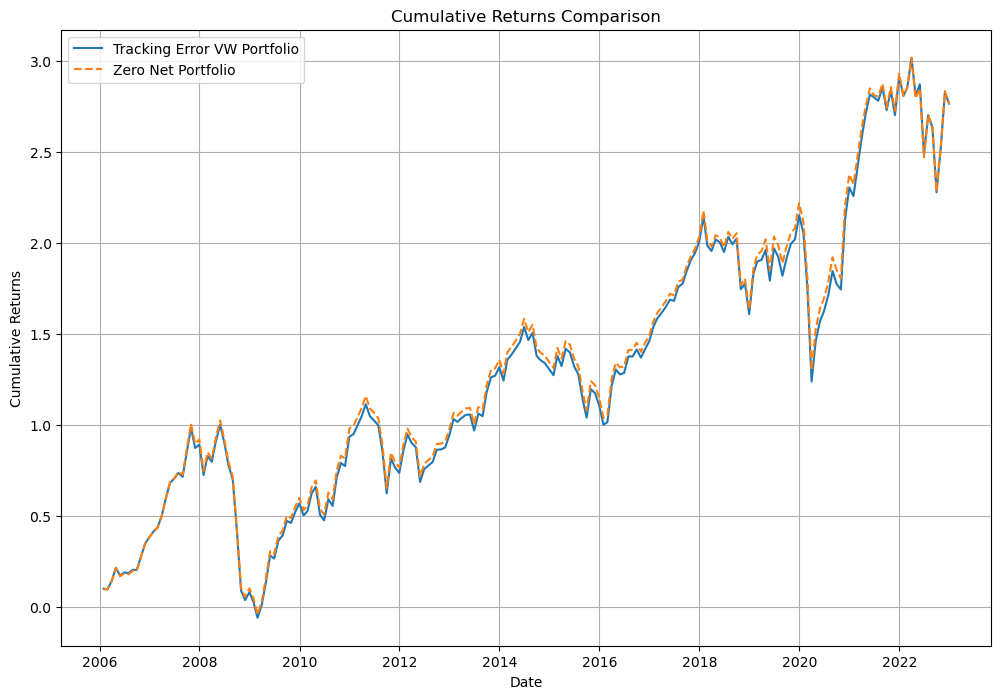

In [119]:
benchmark_cumulative_returns_te = (1 + portfolio_returns_tracking_error).cumprod() - 1
benchmark_cumulative_returns_nz = (1 + portfolio_returns_net_zero).cumprod() - 1


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(benchmark_cumulative_returns_te.index, benchmark_cumulative_returns_te, label='Tracking Error VW Portfolio')
plt.plot(benchmark_cumulative_returns_nz.index, benchmark_cumulative_returns_nz, label='Zero Net Portfolio', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
# Compute performance metrics for cf
annual_returns_nz = portfolio_returns_net_zero.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return_nz = annual_returns_nz.mean()
annualized_volatility_nz = annual_returns_nz.std() * np.sqrt(12)
sharpe_ratio_nz = annualized_return_nz / annualized_volatility_nz
cumulative_returns_nz = (1 + portfolio_returns_net_zero.fillna(0)).cumprod()
peak_nz = cumulative_returns_nz.expanding(min_periods=1).max()
drawdown_nz = (cumulative_returns_nz - peak_nz) / peak_nz
max_drawdown_nz = drawdown_nz.min()

# Compute performance metrics for cf
annual_returns_te = portfolio_returns_tracking_error.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annualized_return_te = annual_returns_te.mean()
annualized_volatility_te = annual_returns_te.std() * np.sqrt(12)
sharpe_ratio_te = annualized_return_te / annualized_volatility_te
cumulative_returns_te = (1 + portfolio_returns_tracking_error.fillna(0)).cumprod()
peak_te = cumulative_returns_te.expanding(min_periods=1).max()
drawdown_te = (cumulative_returns_te - peak_te) / peak_te
max_drawdown_te = drawdown_te.min()


stats = pd.DataFrame({
    'Annualized Returns': [annualized_return_nz, annualized_return_te],
    'Annualized Volatilities': [annualized_volatility_nz, annualized_volatility_te],
    'Sharpe Ratio': [
        sharpe_ratio_nz,
        sharpe_ratio_te
    ],
    'Max Drawdown': [
        max_drawdown_nz,
        max_drawdown_te
    ], 
    'Max returns': [portfolio_returns_net_zero.max(), portfolio_returns_tracking_error.max()], 
    'Min returns': [portfolio_returns_net_zero.min(), portfolio_returns_tracking_error.min()]
}, index=['Net Zero Portfolio', 'Tracking Error VW Portfolio'])
print(stats)


                             Annualized Returns  Annualized Volatilities  \
Net Zero Portfolio                     0.105041                 0.769722   
Tracking Error VW Portfolio            0.104917                 0.764729   

                             Sharpe Ratio  Max Drawdown  Max returns  \
Net Zero Portfolio               0.136466     -0.526100     0.141370   
Tracking Error VW Portfolio      0.137194     -0.529423     0.138809   

                             Min returns  
Net Zero Portfolio             -0.230424  
Tracking Error VW Portfolio    -0.233124  
